In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

# Code for data extraction
1. In this section we will load the raw data and extract utilization and frequency value

In [4]:
utilData = pd.read_csv('./Util_Run1.csv')
utilData.shape

(2674, 6)

In [5]:
utilData.head()

,memUse,memTot,memfreq,cpuid,cpuload,cpufreq
0,604872,4612865,165000000,0,31,600000
1,675,28712,275000000,0,4,200000
2,1191888,12624777,413000000,0,8,200000
3,773492,8196989,275000000,0,9,300000
4,1144,57890,206000000,0,7,300000


In [6]:
utilData['memLoad'] = utilData['memUse']*100/utilData['memTot']
utilData['memScore'] = utilData['memLoad']*utilData['memfreq']/825000000
utilData['memF'] = utilData['memfreq']*100/825000000

In [7]:
utilData['cpuScore'] = utilData['cpuload']*utilData['cpufreq']/1400000
utilData['cpuF'] = utilData['cpufreq']*100/1000000

In [8]:
utilData.head()

,memUse,memTot,memfreq,cpuid,cpuload,cpufreq,memLoad,memScore,memF,cpuScore,cpuF
0,604872,4612865,165000000,0,31,600000,13.112718,2.622544,20.000000,13.285714,60.0
1,675,28712,275000000,0,4,200000,2.350933,0.783644,33.333333,0.571429,20.0
2,1191888,12624777,413000000,0,8,200000,9.440864,4.726154,50.060606,1.142857,20.0
3,773492,8196989,275000000,0,9,300000,9.436294,3.145431,33.333333,1.928571,30.0
4,1144,57890,206000000,0,7,300000,1.976162,0.493442,24.969697,1.500000,30.0


In [9]:
tot_train = utilData.iloc[0:2136]


In [10]:
train_1 = utilData.iloc[0:534]
train_2 = utilData.iloc[534:1068]
train_3 = utilData.iloc[1068:1602]
train_4 = utilData.iloc[1602:2136]
test_data = utilData.iloc[2136:]
print(train_1.tail())
test_data.shape

      memUse   memTot    memfreq  cpuid  cpuload  cpufreq    memLoad  \
529    41341   464426  825000000      0       50   800000   8.901526   
530    41341   464426  825000000      0       33   600000   8.901526   
531    41341   464426  825000000      0       30   600000   8.901526   
532    41341   464426  825000000      0       29   500000   8.901526   
533  2457799  3939455  825000000      0       40   700000  62.389315   

      memScore   memF   cpuScore  cpuF  
529   8.901526  100.0  28.571429  80.0  
530   8.901526  100.0  14.142857  60.0  
531   8.901526  100.0  12.857143  60.0  
532   8.901526  100.0  10.357143  50.0  
533  62.389315  100.0  20.000000  70.0  


(538, 11)

# Modeling 
In this section we will model the data and test its accuracy

In [90]:
model = ARIMA(tot_train['cpuF'], order=(2,0,[2]), exog=tot_train[['cpuload','cpuScore']])
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                 2136
Model:               ARIMA(2, 0, [2])   Log Likelihood               -6796.156
Date:                Tue, 06 Jun 2023   AIC                          13606.312
Time:                        13:27:37   BIC                          13645.979
Sample:                             0   HQIC                         13620.829
                               - 2136                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7475      1.361     18.913      0.000      23.079      28.416
cpuload        0.7752      0.021     37.439      0.000       0.735       0.816
cpuScore       0.3607      0.022     16.721      0.0

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [86]:
model1 = ARIMA(train_1['cpuF'], order=(2,0,2), exog=train_1['cpuScore'])
result1 = model1.fit()
print(result1.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  534
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1677.971
Date:                Tue, 06 Jun 2023   AIC                           3369.942
Time:                        13:25:36   BIC                           3399.905
Sample:                             0   HQIC                          3381.666
                                - 534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.7149      0.903     32.916      0.000      27.945      31.484
cpuScore       1.2713      0.019     66.205      0.000       1.234       1.309
ar.L1          0.0813      0.830      0.098      0.9

In [87]:
model2 = ARIMA(train_2['cpuF'], order=(2,0,1), exog=train_2['cpuScore'])
result2 = model2.fit()
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  534
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1599.439
Date:                Tue, 06 Jun 2023   AIC                           3210.877
Time:                        13:26:02   BIC                           3236.559
Sample:                             0   HQIC                          3220.926
                                - 534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.7742      0.442    112.602      0.000      48.908      50.641
cpuScore       0.9393      0.011     88.506      0.000       0.919       0.960
ar.L1          0.5820      0.275      2.114      0.0

In [88]:
model3 = ARIMA(train_3['cpuF'], order=(2,0,1), exog=train_3['cpuScore'])
result3 = model3.fit()
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  534
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1787.734
Date:                Tue, 06 Jun 2023   AIC                           3587.468
Time:                        13:26:19   BIC                           3613.150
Sample:                             0   HQIC                          3597.517
                                - 534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.2394      3.346     10.530      0.000      28.680      41.798
cpuScore       1.0555      0.021     49.487      0.000       1.014       1.097
ar.L1          1.0417      0.053     19.770      0.0

In [15]:
model4 = ARIMA(train_4['cpuF'], order=(4,0,1), exog=train_4['cpuScore'])
result4 = model4.fit()
print(result4.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  534
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -1814.247
Date:                Tue, 06 Jun 2023   AIC                           3644.493
Time:                        12:51:35   BIC                           3678.737
Sample:                             0   HQIC                          3657.892
                                - 534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2761      0.855     35.424      0.000      28.601      31.951
cpuScore       1.1431      0.023     49.682      0.000       1.098       1.188
ar.L1         -0.0924      0.406     -0.227      0.8

## Testing Accuracy
We will run both the models to test its accuracy

In [16]:
# This is to test the accuracy of prediction
from sklearn import metrics

In [17]:
forecast = result.forecast(steps=538,exog=test_data['cpuScore'])
forecast = forecast.to_numpy()

In [18]:
forecast1 = result1.forecast(steps=538,exog=test_data['cpuScore'])
forecast1 = forecast1.to_numpy()

In [19]:
forecast2 = result2.forecast(steps=538,exog=test_data['cpuScore'])
forecast2 = forecast2.to_numpy()

In [20]:
forecast3 = result3.forecast(steps=538,exog=test_data['cpuScore'])
forecast3 = forecast3.to_numpy()

In [21]:
forecast4 = result4.forecast(steps=538,exog=test_data['cpuScore'])
forecast4 = forecast4.to_numpy()

In [22]:
y_true = test_data['cpuF'].to_numpy()

In [23]:
print('RMSE', np.sqrt(metrics.mean_squared_error(y_true,forecast)))

RMSE 8.356458526958226


In [24]:
print('RMSE_1', np.sqrt(metrics.mean_squared_error(y_true,forecast1)))

RMSE_1 9.980224894788694


In [25]:
print('RMSE_2', np.sqrt(metrics.mean_squared_error(y_true,forecast2)))

RMSE_2 18.39404567737297


In [26]:
print('RMSE_3', np.sqrt(metrics.mean_squared_error(y_true,forecast3)))

RMSE_3 9.11312736498099


In [27]:
print('RMSE_4', np.sqrt(metrics.mean_squared_error(y_true,forecast4)))

RMSE_4 6.822845741543657


# Splitting the time series
1. We will split the time series in fragments of 25 entries and then create 4 different entries and merge to train the data

In [28]:
strain_1 = utilData.iloc[0:25]
strain_2 = utilData.iloc[25:50]
strain_3 = utilData.iloc[50:75]
strain_4 = utilData.iloc[75:100]
stest_data = utilData.iloc[2200:]
stest_data.shape

(474, 11)

In [29]:
strain_1.tail()

,memUse,memTot,memfreq,cpuid,cpuload,cpufreq,memLoad,memScore,memF,cpuScore,cpuF
20,731460,7728405,275000000,0,11,300000,9.464566,3.154855,33.333333,2.357143,30.0
21,731460,7728405,275000000,0,10,300000,9.464566,3.154855,33.333333,2.142857,30.0
22,731460,7728405,275000000,0,12,300000,9.464566,3.154855,33.333333,2.571429,30.0
23,731460,7728405,275000000,0,11,300000,9.464566,3.154855,33.333333,2.357143,30.0
24,731460,7728405,275000000,0,9,300000,9.464566,3.154855,33.333333,1.928571,30.0


In [30]:
# We create our data here
for i in range(100,2136,100):
    i_1,i_2,i_3,i_4 = i,i+25,i+50,i+75
    i_end = i+100
    strain_1 = strain_1.append(utilData.iloc[i_1:i_2],ignore_index=True)
    strain_2 = strain_2.append(utilData.iloc[i_2:i_3],ignore_index=True)
    strain_3 = strain_3.append(utilData.iloc[i_3:i_4],ignore_index=True)
    strain_4 = strain_4.append(utilData.iloc[i_4:i_end],ignore_index=True)

In [31]:
strain_4.shape

(550, 11)

## Modeling the split time series
We are using the newly generated split dataset to train and verify its acuracy

In [32]:
smodel1 = ARIMA(strain_1['cpuScore'], order=(4,0,1), exog=strain_1['cpuF'])
sresult1 = smodel1.fit()
print(sresult1.summary())

                               SARIMAX Results                                
Dep. Variable:               cpuScore   No. Observations:                  550
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -1692.357
Date:                Tue, 06 Jun 2023   AIC                           3400.714
Time:                        12:51:36   BIC                           3435.193
Sample:                             0   HQIC                          3414.188
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -23.3906      1.503    -15.557      0.000     -26.337     -20.444
cpuF           0.7832      0.008    101.068      0.000       0.768       0.798
ar.L1         -0.2544      0.316     -0.805      0.4

In [33]:
smodel2 = ARIMA(strain_2['cpuF'], order=(4,0,1), exog=strain_2['cpuScore'])
sresult2 = smodel2.fit()
print(sresult2.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  550
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -1727.989
Date:                Tue, 06 Jun 2023   AIC                           3471.977
Time:                        12:51:36   BIC                           3506.457
Sample:                             0   HQIC                          3485.451
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.2275      2.495     13.720      0.000      29.338      39.117
cpuScore       1.1096      0.015     72.491      0.000       1.080       1.140
ar.L1          1.2486      0.142      8.818      0.0

In [34]:
smodel3 = ARIMA(strain_3['cpuF'], order=(4,0,1), exog=strain_3['cpuScore'])
sresult3 = smodel3.fit()
print(sresult3.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  550
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -1873.463
Date:                Tue, 06 Jun 2023   AIC                           3762.926
Time:                        12:51:37   BIC                           3797.406
Sample:                             0   HQIC                          3776.400
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.8708      3.170     11.000      0.000      28.657      41.084
cpuScore       1.0762      0.022     49.627      0.000       1.034       1.119
ar.L1          1.0832      0.057     18.881      0.0

In [35]:
smodel4 = ARIMA(strain_4['cpuF'], order=(4,0,1), exog=strain_4['cpuScore'])
sresult4 = smodel4.fit()
print(sresult4.summary())

                               SARIMAX Results                                
Dep. Variable:                   cpuF   No. Observations:                  550
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -1827.922
Date:                Tue, 06 Jun 2023   AIC                           3671.845
Time:                        12:51:37   BIC                           3706.324
Sample:                             0   HQIC                          3685.319
                                - 550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.9780      1.572     22.249      0.000      31.897      38.059
cpuScore       1.1037      0.026     41.984      0.000       1.052       1.155
ar.L1          0.2633      0.227      1.162      0.2

## Prediction Phase for split
We are calculating the RMSE of the models

In [36]:
sforecast1 = sresult1.forecast(steps=474,exog=stest_data['cpuScore'])
sforecast1 = sforecast1.to_numpy()

In [37]:
sy_true = stest_data['cpuF'].to_numpy()

In [38]:
print('RMSE_1', np.sqrt(metrics.mean_squared_error(sy_true,sforecast1)))

RMSE_1 62.02337498760633


In [39]:
sforecast2 = sresult2.forecast(steps=474,exog=stest_data['cpuScore'])
sforecast2 = sforecast2.to_numpy()

In [40]:
print('RMSE_2', np.sqrt(metrics.mean_squared_error(sy_true,sforecast2)))

RMSE_2 8.536672643340497


In [41]:
sforecast3 = sresult3.forecast(steps=474,exog=stest_data['cpuScore'])
sforecast3 = sforecast3.to_numpy()

In [42]:
print('RMSE_3', np.sqrt(metrics.mean_squared_error(sy_true,sforecast3)))

RMSE_3 8.776180011531672


In [43]:
sforecast4 = sresult4.forecast(steps=474,exog=stest_data['cpuScore'])
sforecast4 = sforecast4.to_numpy()

In [44]:
print('RMSE_4', np.sqrt(metrics.mean_squared_error(sy_true,sforecast4)))

RMSE_4 8.903101869699041


### Note; the results are better for smaller prediction interval. 
Does it mean we need to retrain every small interval. (We did 100 v. 474)
That is not an effective prediction model

# Grouping the data by a column
We will now model for each state of the cpufrequency

In [45]:
#Get the unique cpuF values
cpuFArr = tot_train['cpuF'].unique()
cpuFArr

array([ 60.,  20.,  30.,  40.,  50., 120.,  70.,  80., 140., 130., 100.,
        90., 110.])

In [46]:
sorted(utilData['memfreq'].unique())

[165000000, 206000000, 275000000, 413000000, 543000000, 825000000]

In [47]:
gtrain = tot_train.groupby(['cpuF'])

In [48]:
gtrain.get_group(60.0)

,memUse,memTot,memfreq,cpuid,cpuload,cpufreq,memLoad,memScore,memF,cpuScore,cpuF
0,604872,4612865,165000000,0,31,600000,13.112718,2.622544,20.000000,13.285714,60.0
12,3742,166275,275000000,0,31,600000,2.250489,0.750163,33.333333,13.285714,60.0
13,3742,166275,275000000,0,40,600000,2.250489,0.750163,33.333333,17.142857,60.0
32,709011,7717381,275000000,0,13,600000,9.187197,3.062399,33.333333,5.571429,60.0
60,1228,46513,275000000,0,30,600000,2.640122,0.880041,33.333333,12.857143,60.0
...,...,...,...,...,...,...,...,...,...,...,...
1934,7212,180508,825000000,0,32,600000,3.995391,3.995391,100.000000,13.714286,60.0
1948,845096,15828949,543000000,0,31,600000,5.338927,3.513985,65.818182,13.285714,60.0
1955,912556,14908785,413000000,0,36,600000,6.120928,3.064174,50.060606,15.428571,60.0
1977,37665,206049,543000000,0,47,600000,18.279633,12.031322,65.818182,20.142857,60.0


In [49]:
mapTrain = {}
for  val in cpuFArr:
    mapTrain[val] = gtrain.get_group(val)

In [50]:
gresult ={}
for val in cpuFArr:
    print("\n\nVal",val)
    gmodel = ARIMA(mapTrain[val]['cpuload'], order=(1,0,1))
    gresult[val] = gmodel.fit()
    print(gresult[val].summary())



Val 60.0
                               SARIMAX Results                                
Dep. Variable:                cpuload   No. Observations:                  198
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -620.984
Date:                Tue, 06 Jun 2023   AIC                           1249.968
Time:                        12:51:37   BIC                           1263.121
Sample:                             0   HQIC                          1255.292
                                - 198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.9655      0.808     40.778      0.000      31.381      34.550
ar.L1          0.7387      0.150      4.939      0.000       0.446       1.032
ma.L1         -0.5437      0.179     -3.0

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported inde

                               SARIMAX Results                                
Dep. Variable:                cpuload   No. Observations:                  210
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -635.945
Date:                Tue, 06 Jun 2023   AIC                           1279.889
Time:                        12:51:37   BIC                           1293.278
Sample:                             0   HQIC                          1285.302
                                - 210                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.9793      1.490      9.380      0.000      11.058      16.900
ar.L1          0.9608      0.051     18.750      0.000       0.860       1.061
ma.L1         -0.8763      0.079    -11.070      0.0

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported inde

                               SARIMAX Results                                
Dep. Variable:                cpuload   No. Observations:                  243
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -103.321
Date:                Tue, 06 Jun 2023   AIC                            214.641
Time:                        12:51:38   BIC                            228.614
Sample:                             0   HQIC                           220.269
                                - 243                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.9524      0.133    750.907      0.000      99.692     100.213
ar.L1          0.8849      1.990      0.445      0.657      -3.015       4.785
ma.L1         -0.9125      1.596     -0.572      0.5

/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dmukherjee/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported inde

### The results are very confusing
What should serve as the endogenous and exogenous variable for this model?

# Plotting the data
Understand how does the state looks like with the change


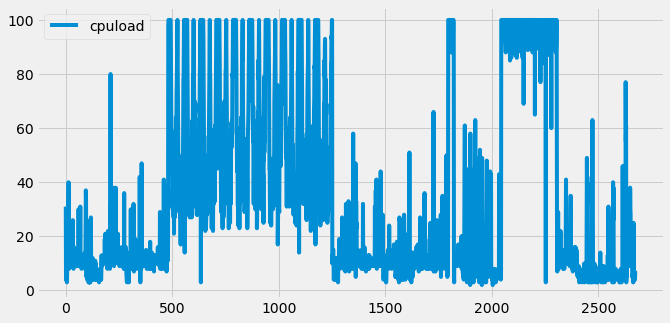

In [51]:
utilData.plot(y='cpuload')

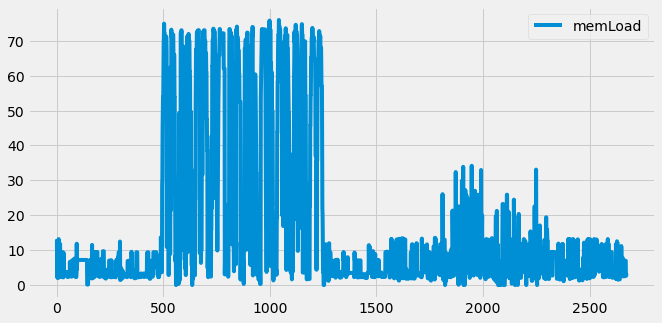

In [52]:
utilData.plot(y='memLoad')

In [53]:
x_axis= utilData.index.values.tolist()

<Figure size 3600x144 with 0 Axes>

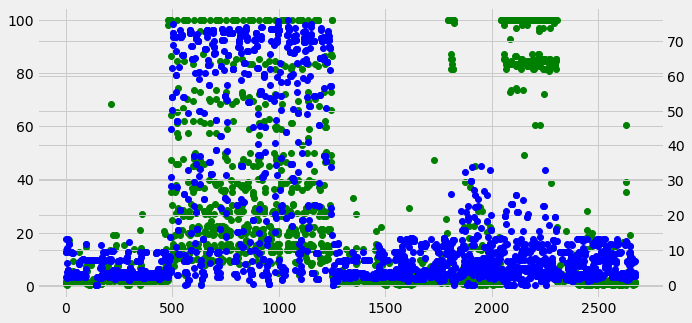

In [54]:
plt.figure(figsize=(50,2))
fig, ax1 = plt.subplots()

x = utilData.index.values.tolist()
y1 = utilData['cpuScore']
y2 = utilData['memLoad']

ax2 = ax1.twinx()

ax1.plot(x, y1, 'go')
ax2.plot(x, y2, 'bo')

In [55]:
# Empty space for plotting more

# Characterizing state and load behaviour
How does cpuload, memload, and their frequencies fare

In [56]:
def diffCorr(x,y):
    print("Pearson",stats.pearsonr(x,y))
    print("Spearman",stats.spearmanr(x,y))

In [57]:
x1 = utilData['cpuF'].to_numpy()
x2 = utilData['memfreq'].to_numpy()
diffCorr(x1,x2)

Pearson (0.3836347504363804, 1.7063228385820354e-94)
Spearman SpearmanrResult(correlation=0.47070653722998695, pvalue=1.5434514304878583e-147)


In [58]:
x1 = utilData['memLoad'].to_numpy()
x2 = utilData['cpuload'].to_numpy()
diffCorr(x1,x2)

Pearson (0.16319251172460278, 2.0338312191249533e-17)
Spearman SpearmanrResult(correlation=0.27231234018077843, pvalue=1.1147530764989117e-46)


In [59]:
x1 = utilData['cpuF'].to_numpy()
x2 = utilData['cpuScore'].to_numpy()
diffCorr(x1,x2)

Pearson (0.9767547511328467, 0.0)
Spearman SpearmanrResult(correlation=0.9563341295204049, pvalue=0.0)


In [60]:
x1 = utilData['memfreq'].to_numpy()
x2 = utilData['memLoad'].to_numpy()
diffCorr(x1,x2)

Pearson (0.6229270915789488, 2.867526676180988e-287)
Spearman SpearmanrResult(correlation=0.5987098763658174, pvalue=7.37488228744494e-260)


In [61]:
x1 = utilData['cpuF'].to_numpy()
x2 = utilData['memLoad'].to_numpy()
diffCorr(x1,x2)

Pearson (0.166601935751212, 4.255277434031809e-18)
Spearman SpearmanrResult(correlation=0.3111704705195926, pvalue=4.017215464125179e-61)


In [62]:
x1 = utilData['memfreq'].to_numpy()
x2 = utilData['cpuScore'].to_numpy()
diffCorr(x1,x2)

Pearson (0.28102522714424977, 1.0101016102936825e-49)
Spearman SpearmanrResult(correlation=0.44547340370761845, pvalue=1.5588595621015236e-130)


In [63]:
x1 = utilData['memF'].to_numpy()
x2 = utilData['cpuScore'].to_numpy()
diffCorr(x1,x2)

Pearson (0.28102522714424977, 1.0101016102936825e-49)
Spearman SpearmanrResult(correlation=0.44547340370761845, pvalue=1.5588595621015236e-130)


### Note: Memory has more cross resource predictive power but cpu is better at its own prediction
We will utilize these values and try run a linear model to check how the coefficients look for a multi-dimensional ARMA model and a linear/other regression model

In [64]:
#Empty space for code

# Plotting PACF and ACF
We need to find out the level of autocorrelation in the values

In [65]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

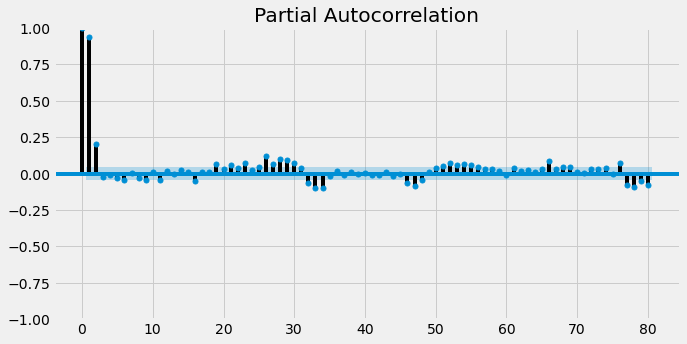

In [66]:
plot_pacf(tot_train['cpuScore'], lags=80, alpha=0.05,method='ols');

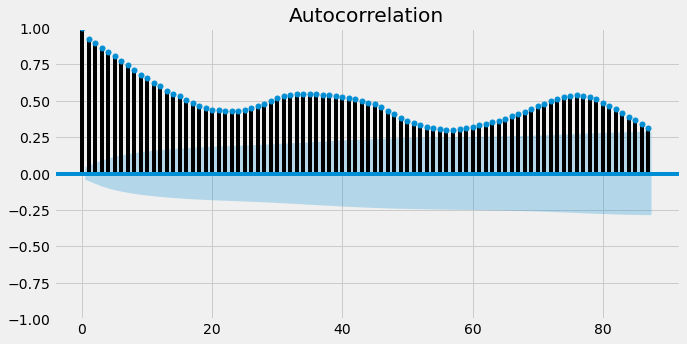

In [67]:
plot_acf(tot_train['cpuload'], lags=87, alpha=0.05);

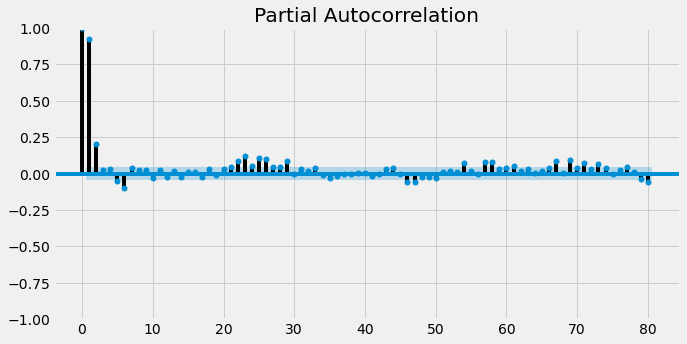

In [68]:
plot_pacf(tot_train['memScore'], lags=80, alpha=0.05,method='ols');

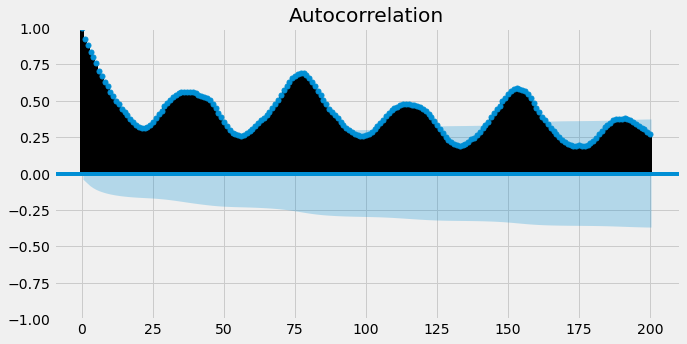

In [69]:
plot_acf(tot_train['memScore'], lags=200, alpha=0.05);

In [70]:
# Space for futher analysis


# Understanding cross value lagged correlation
Using xcorr to get the idea of lagged dependency among variables

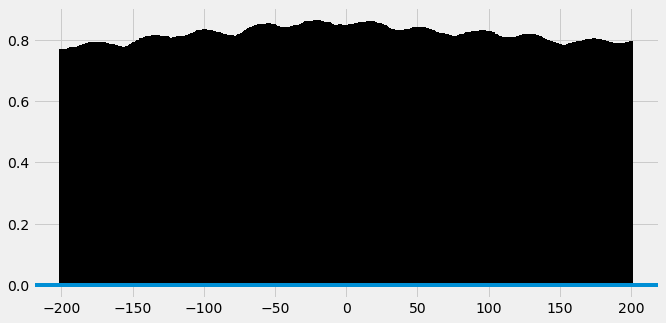

In [71]:
x1 = utilData['cpuF'].to_numpy()
x2 = utilData['memF'].to_numpy()
plt.xcorr(x1,x2,normed=True,maxlags=200);

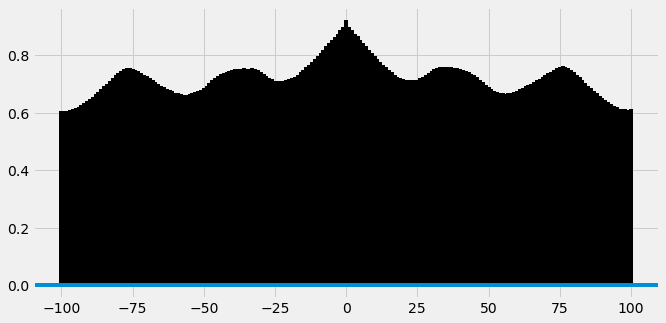

In [72]:
x1 = utilData['cpuF'].to_numpy()
x2 = utilData['cpuScore'].to_numpy()
plt.xcorr(x1,x2,normed=True,maxlags=100);

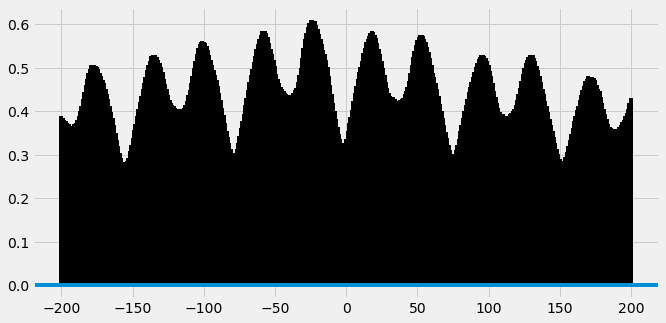

In [73]:
x1 = utilData['cpuScore'].to_numpy()
x2 = utilData['memScore'].to_numpy()
plt.xcorr(x1,x2,normed=True,usevlines=True,maxlags=200);

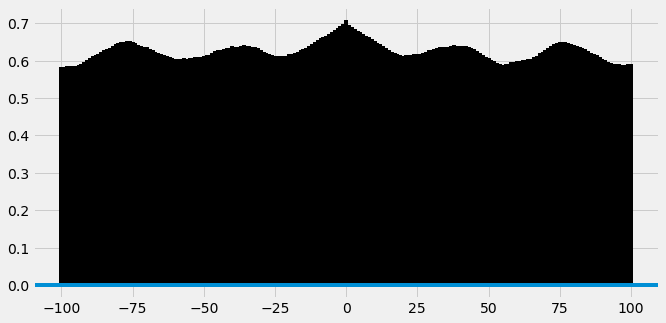

In [74]:
x1 = utilData['memF'].to_numpy()
x2 = utilData['memScore'].to_numpy()
plt.xcorr(x1,x2,normed=True,maxlags=100);

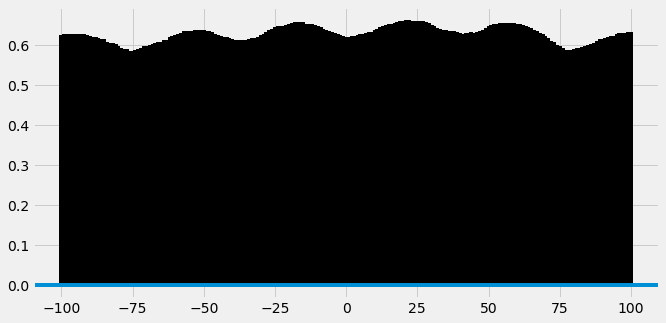

In [75]:
x1 = utilData['memF'].to_numpy()
x2 = utilData['cpuScore'].to_numpy()
plt.xcorr(x1,x2,normed=True,usevlines=True,maxlags=100);